# Self-Driving Car Engineer Nanodegree

## Computer Vision and Deep Learning

### Project: Advanced Lane Finding

This notebook contains the implementation of teh Advanced Lane Finding project.  The overall goal of this project is to develop a pipeline that will identify the lane boundries from the front-facing, centered video on a car.  The project needs to include camera calibration in addition to lane discovery.


## Step 0: Import Statements

In [64]:
### Consolidated import statements
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import imageio
%matplotlib inline

# Show versions
print("Numpy: " + np.__version__)
print("CV2: " + cv2.__version__)


Numpy: 1.12.0
CV2: 3.1.0


## Step 1: Calibrate Camera
This section calibrates the camera using the calibration images with checkerboard shot from different angles, positions, and orientations to the camera.  To demonstrate success, the code will show an example of an undistorted image.

In [2]:
### This cell creates template for object points for targets in calibration in array objp
### Requires: Correction number of x and y points inserted below in nx and ny variables
### Creates: objp - array used as template for object points

# Prepare object point template = (0,0,0), (1,0,0), ...., (nx-1, ny-1, 0)
nx = 9
ny = 6
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)


# Test = show proper array
#print(objp)


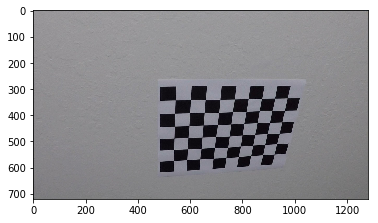

In [3]:
### This cell load calibration images into cal_images[] array
### Requires: Correct path and file name standard (assumes incremental file names starting at 1 with 
###                basename and extension)
###           Quatity of images entered in cal_img_qty
### Creates: cal_images - array of calibration image from the files loaded with mpimg

# File structure
cal_img_path = './camera_cal/'
cal_img_basename = 'calibration'
cal_img_extension = '.jpg'
cal_img_qty = 21

# Load images
cal_images = []
for i in range(1, cal_img_qty):
    img = mpimg.imread(cal_img_path + cal_img_basename + str(i) + cal_img_extension)
    cal_images.append(img)
    
# Test = show random image
plt.imshow(cal_images[random.randrange(cal_img_qty)])   


In [4]:
### This cell goes through each image and finds chessboard corners and creates cooresponding
### objpoints/imgpoints arrays.  If corners are not found, this cell will put in placeholders so 
### the image can be viewed in test code for troubleshooting.  They will be dropped before 
### further processing.
### NOTE: Before executing this after the first time, make sure to re-load the original images
### Requires: objp - array used as template for object points
###           cal_images - array of calibration image from the files loaded with mpimg
### Creates: objpoints - array of 3d points in "real" space
###          imgpoints - array of 2d points found in each calibration image
###          problem_images - list of images where corners were not found

objpoints = [] # 3d points in "real" space
imgpoints = [] # 2d points in image
problem_images = [] # List of image indexes where corners could not be found

for i in range(len(cal_images)):
    # Convert to gray
    gray = cv2.cvtColor(cal_images[i], cv2.COLOR_RGB2GRAY)

    # Find corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny))
    
    # If corners found, add object and image points and draw corners on original cal_images
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        cv2.drawChessboardCorners(cal_images[i], (nx, ny), corners, ret)
    
    # If corners not found, notify in ouput, add temporary placeholders
    if ret == False:
        problem_images.append(i)
        objpoints.append(np.zeros_like(objp))
        imgpoints.append(np.zeros(nx * ny * 2).reshape(nx * ny, 1, 2))
        print("Corners not found in image # {}".format(i+1))
        
    

Corners not found in image # 1
Corners not found in image # 4
Corners not found in image # 5


Image # 1
[[ 0.  0.]] [[ 0.  0.]]
Corners not found


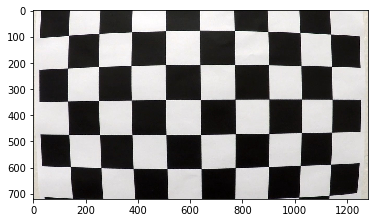

In [5]:
### Test code for finding the chessboard corners.  Each execution will iterate to the next image
### in sequence.  Test = print the found imagepoints and show image with found corners.

# Track execution sequence
try: x += 1
except NameError: x = 0
if x >= len(imgpoints): x = 0
print("Image # {}".format(x + 1))

# Print first and lastimgpoints and show img
print(imgpoints[x][0], imgpoints[x][-1])
if x in problem_images: print("Corners not found")
plt.imshow(cal_images[x])

In [6]:
### This cell drops out problem imgpoints/objpoints
### Requires: objpoints, imgpoints - arrays of target and discovered corners from calibration images
### Updates: imgpoints - removes indexed items where corners were not found
###          problem_image - clears to avoid removing additional images on subsequent runs
### Creates: problem_images_old - to hold original listing of problem image indexes
orig_len = len(imgpoints)
for i in reversed(problem_images):
    print("Removing index: {}".format(i))
    del imgpoints[i]
    del objpoints[i]
assert orig_len - len(problem_images) == len(imgpoints)
assert len(imgpoints) == len(objpoints)
problem_images_old = problem_images
problem_images = []

Removing index: 4
Removing index: 3
Removing index: 0


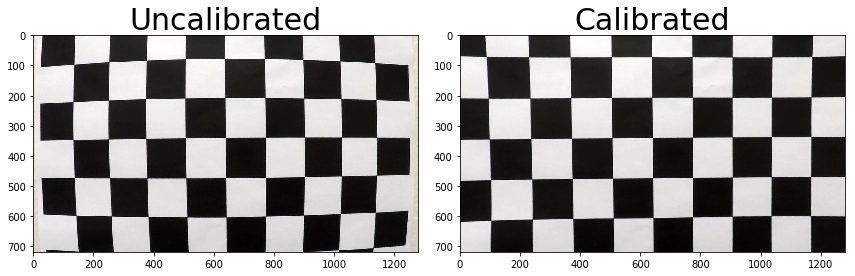

In [7]:
### This cell contains the function the calibraed camera values and 
### displays uncalibrated and calibrated images (based on image 1)
### Requires: objpoints, imgpoints - arrays of target and discovered corners from calibration images
###           cal_images - array of calibration images (for test display)
### Creates: ret, mtx, dist, rvecs, tvecs - results from camera calibration including calibration vectors
###          cal_undistort(img) - function to undistort images based on global calibration vectors

# Compute distortion vectors
ret, mtx, dist, rvecs, tvecs = \
        cv2.calibrateCamera(objpoints, imgpoints, cal_images[0].shape[0:2], None, None)

# Define cal_undistort() function
def cal_undistort(img):
    '''
    Return the undistorted image using vectors in already established global variables mtx and dist
    :img: image to be undistorted
    :return: undistorted image
    '''
    return cv2.undistort(img, mtx, dist, None, mtx)

# Display uncalibrated and calibrated images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
f.tight_layout()
ax1.imshow(cal_images[0])
ax1.set_title('Uncalibrated', fontsize=30)
ax2.imshow(cal_undistort(cal_images[0]))
ax2.set_title('Calibrated', fontsize=30)


## Step 2: Determine "Top-down" Distortion
This section uses straig_line image samples to create a distortion function that provides a "top-down" view of the area where the lane-lines are located.  This approach assumes that the camera is centered on the car and the car is generally centered in a straight, flat lane.

For now, the next set of code cells in this function walk through a manual calibration of Top-Down distortion.

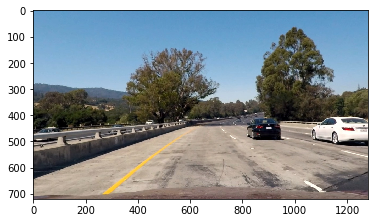

In [8]:
### Load straight-line and test images.  This will also run camera calibration.
### Requires: Correct path and file name standard (for test images, assumes incremental file  
###                names starting at 1 with basename and extension)
###           Quatity of images entered in cal_img_qty
### Creates: straight_img1, straight_img2 - images to be used for creating and confirming 
###               "top-down" distortion
###          test_images - array of calibration image from the files loaded with mpimg

# File structures
test_img_path = './test_images/'
straight_img1_name = 'straight_lines1.jpg'
straight_img2_name = 'straight_lines2.jpg'
test_img_basename = 'test'
test_img_extension = '.jpg'
test_img_qty = 6

# Load straight images
straight_img1 = cal_undistort(mpimg.imread(test_img_path + straight_img1_name))
straight_img2 = cal_undistort(mpimg.imread(test_img_path + straight_img2_name))

# Load test images
test_images = []
for i in range(1, test_img_qty+1):
    img = mpimg.imread(test_img_path + test_img_basename + str(i) + test_img_extension)
    test_images.append(cal_undistort(img))
    
# Test = show random image
plt.imshow(test_images[random.randrange(test_img_qty)])   


In [9]:
### This section simply saves an undistorted version of straight-lines1 for purpose of finding src points
mpimg.imsave(test_img_path + 'straight_lines1_undistorted.jpg', straight_img1)

(720, 1280)
(1280, 720)


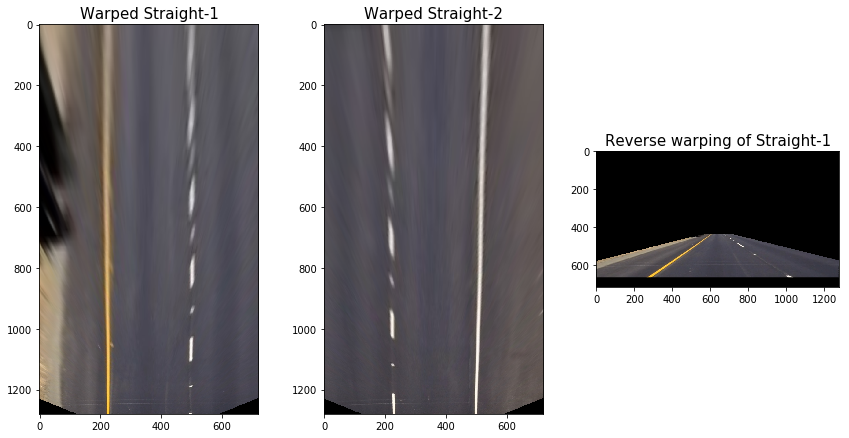

In [10]:
### This section will create perspective transform and its inverse.  The specific source and destination
### values are manually entered based on the straight-line image (used the first one).
### src points are taken manually (I used Pinta to get points).  These values are then 
### Requires: Manually specified source and destination points to define rectangles for distortion
### Creates: src - array with 4 x,y points representing rectangular area in straight-line image
###          dst - array with 4 x,y points representing desired positioning after distortion

src = np.float32([[609, 442], [670, 442],
                 [281, 668], [1022, 668]])
offset = 225
img_size = [720, 1280]
dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                  [offset, img_size[1]-1], [img_size[0]-offset, img_size[1]-1]])

# Calculate perspective transform and inverse.
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

# Define warp() and unwarp() functions
def warp(undist_img):
    '''
    Return an image warped to show a "top-down" view of the region included with an offset on
      top, left, and right to include extra range
    :undist_img: an image adjusted for camera distortion
    :return: a warped image based showing just the defined rectangle + offsets
    '''
    return cv2.warpPerspective(undist_img, M, undist_img.shape[0:2])

def unwarp(img):
    '''
    Return an image with data to overlay on original undistorted image.  This is intended to
      be able to return graphed data (e.g., lane polygon) combining with original image.
    :img: image to be restored to original proportions
    :return: an image restored to original (camera-calibrated) proportions
    '''
    return cv2.warpPerspective(img, Minv, img.shape[0:2])


# Test: show warped image for both straight-line sets and reverse one of the warped images

warped1 = warp(straight_img1)
warped2 = warp(straight_img2)
unwarped1 = unwarp(warped1)
print(straight_img1.shape[0:2])
print(warped1.shape[0:2])
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))
f.tight_layout()
ax1.imshow(warped1)
ax1.set_title('Warped Straight-1', fontsize=15)
ax2.imshow(warped2)
ax2.set_title('Warped Straight-2', fontsize=15)
ax3.imshow(unwarped1)
ax3.set_title('Reverse warping of Straight-1', fontsize=15)

mpimg.imsave('mytmpimg.jpg', warped1)

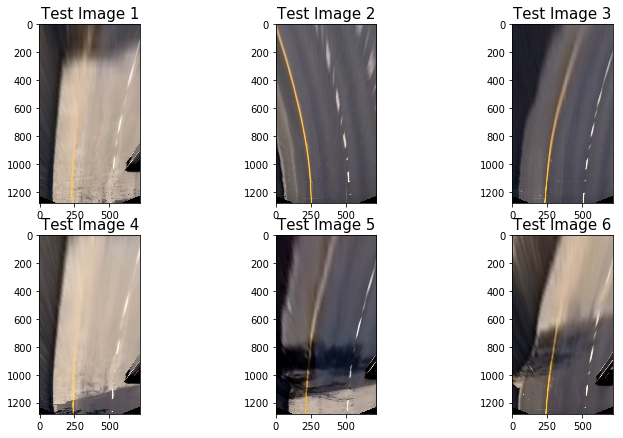

In [11]:
### Create new warped images and simply display each of the test images in undistorted, "top-down" view
### Requires: test_images - array of 6 test images 
###           warp() - function to warp images
### Creates: warped_images - array of 6 "top-down" images
warped_images = []
for image in test_images:
    warped_images.append(warp(image))

def show6images(images):
    '''
    This function simply displays six images provided in 2 rows, each labeled Test Image #.
    :images: array of six images
    :returns: nothing
    '''
    f, axes = plt.subplots(2, 3, figsize=(10, 6))
    f.tight_layout()
    testidx = 0
    for row in axes:
        for axis in row:
            axis.imshow(images[testidx])
            axis.set_title('Test Image ' + str(testidx + 1), fontsize=15)
            testidx += 1

show6images(warped_images)

## Step 3: Highlight lane lines

In [12]:
### Define threshold functions
### Requires: Nothing
### Creates: apply_thresh() - Helper function to apply threshold based on different metrics
###          abs_sobel_thresh() - Calculates directional gradient
###          mag_thresh() - Calculates gradient magnitude
###          dir_threshold() - Calculates gradient direction

def apply_thresh(img, thresh):
    '''
    This helper function is used by various threshold functions below to create new array the 
    same size as img that has 1 or 0 depending on provided thresh values
    :img: image to be used for threshold calculation
    :thresh: tuple identifying the low and high values for filtering sobel results
    '''
    thresh_img = np.zeros_like(img)
    thresh_img[(img>=thresh[0]) & (img<=thresh[1])] = 1
    return thresh_img

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    '''
    This function calculates the directional gradient across either the x or y axis as
    provided using the Sobel function.  It will return an array of same size with 1's 
    or zeros depending on threshold match.
    :img: image to be used for threshold calculation
    :orient: orientation of the directional gradient ('x' or 'y' axis)
    :sobel_kernel: kernel value for Sobel filter size, must be an odd number
    :thresh: tuple identifying the low and high values for filtering sobel results
    '''
    assert sobel_kernel%2 == 1
    
    # calculate directional gradient
    if orient=='x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
        
    # apply threshold
    grad_binary = apply_thresh(scaled_sobel, thresh)
    
    return grad_binary

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    '''
    This function calculates the gradient magnitude based on x and y sobel values
    It will return an array of same size with 1's or zeros depending on threshold match.
    :img: image to be used for threshold calculation
    :sobel_kernel: kernel value for Sobel filter size, must be an odd number
    :thresh: tuple identifying the low and high values for filtering sobel results
    '''
    assert sobel_kernel%2 == 1
    
    # calculate gradient magnitude
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    magnitude = np.sqrt(np.square(sobelx) + np.square(sobely))
    scaled_mag = np.uint8(255*magnitude / np.max(magnitude))
    
    # apply threshold
    mag_binary = apply_thresh(scaled_mag, thresh)
    
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    '''
    This function calculates the gradient direction based on x and y sobel values
    It will return an array of same size with 1's or zeros depending on threshold match.
    :img: image to be used for threshold calculation
    :sobel_kernel: kernel value for Sobel filter size, must be an odd number
    :thresh: tuple identifying the low and high values for filtering sobel results
    '''
    assert sobel_kernel%2 == 1
    
    # calculate gradient direction
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    sobel_gd = np.arctan2(abs_sobely, abs_sobelx)
    
    # apply threshold
    dir_binary = apply_thresh(sobel_gd, thresh)
    
    return dir_binary

def hls_select(s, thresh=(0, 255)):
    '''
    This function returns a new array with same size as color image highlighting parts of
    by the s-channel of HLS color space using threshold values provided
    :img: image to be used for threshold calculation
    :thresh: tuple identifying the low and high values for filtering sobel results
    '''
    
    # apply a threshold to the S channel
    binary_output = apply_thresh(s, thresh)
    
    return binary_output

In [13]:
### This cell defines the image highlighting function.  The function is defined by using 
### different threshold functions defined above
def highlight(image):
    '''
    Function returns an image higlighted using threshold functions.  A lot of tweaking
    went into creating this, but ultimately it highlights pixes with yellow hues and saturation, 
    and uses the lightness and saturation of HLS color to detect gradient changes and combine
    x, y, magnitude and direction into a single binary result.
    :image: full color image (RGB) to be processed
    :return: binary image highlighting lane lines
    '''
    ksize = 7
    
    # yellow thresholds
    yellow_h_min = 10
    yellow_h_max = 25
    yellow_s_min = 90
    yellow_s_max = 255
        
    # convert to HLS color space and threshold
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    h_img = hls[:,:,0]
    l_img = hls[:,:,1]
    s_img = hls[:,:,2]
    yellow_h_binary = hls_select(h_img, thresh=(yellow_h_min, yellow_h_max))
    yellow_s_binary = hls_select(s_img, thresh=(yellow_s_min, yellow_s_max))
    yellow_binary = cv2.bitwise_and(yellow_h_binary, yellow_s_binary)

    # calculate combined gradient binary view
    comb_grad_s = gradient_combined(s_img, ksize)
    comb_grad_l = gradient_combined(l_img, ksize)
    
    # combine yellow and both gradient views
    combined = np.zeros_like(yellow_binary)
    combined[(yellow_binary == 1) | (comb_grad_s == 1) | (comb_grad_l == 1)] = 1
    
    return combined

def gradient_combined(img, ksize):
    '''
    Function applies a combination of line gradient over x and y and the gradient vector over 
    magnitude and direction.  It combines the four values as (x AND y) OR (MAG & DIR).
    :img: single color dimension image input
    :return: binary image output with combined gradient calculation
    '''
    # Determine individual components
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(50, 150))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(50, 150))
    mag = mag_thresh(img, sobel_kernel=ksize, thresh=(40, 150))
    direction = dir_threshold(img, sobel_kernel=ksize, thresh=(0.7, 1.2))
    
    # Combine compoents with bit-wise comparisons
    combined = np.zeros_like(gradx)
    combined[((gradx == 1) & (grady == 1)) | ((mag == 1) & (direction == 1))] = 1
    return combined
    

# Highlight and then warp each test image
highlighted_images = []
lane_images = []
for image in test_images:
    highlighted_images.append(highlight(image))
    lane_images.append(warp(highlight(image)))
    

    

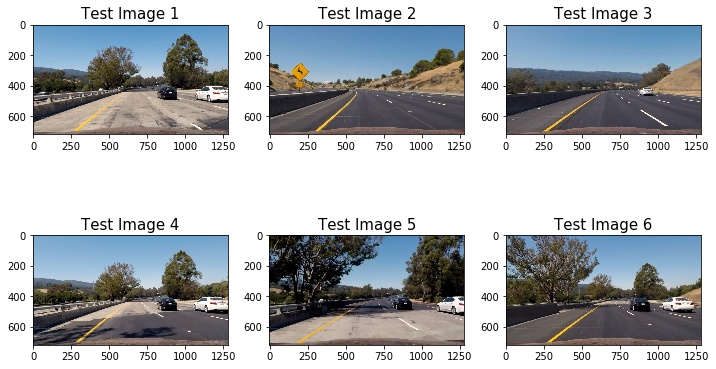

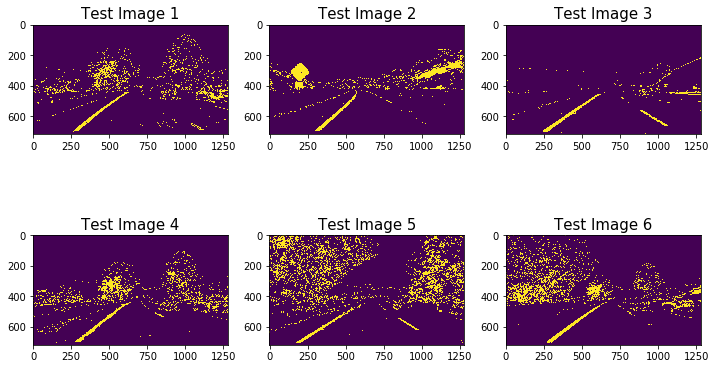

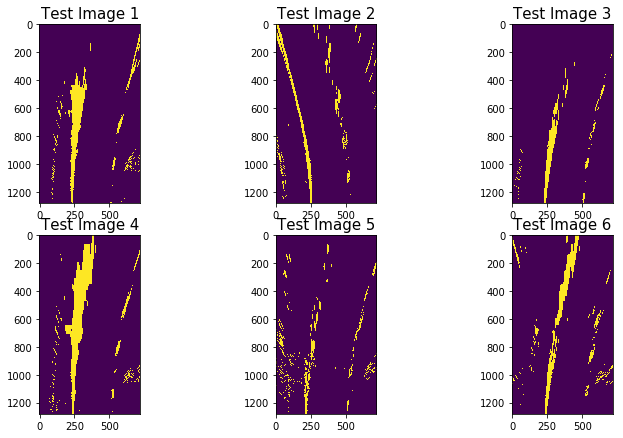

In [14]:
### Simply show the six highlighted images and six warped, highlighted images
show6images(test_images)
show6images(highlighted_images)
show6images(lane_images)

## Step 3: Single Image Sliding Boxes

Starting left center: 263; Starting right center: 583
 Left line: y = 6.65e-05x**2 + -0.26x + 463.27
Right line: y = 1.19e-04x**2 + -0.33x + 761.88


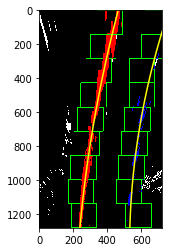

In [18]:
### This section creates a function and demonstrates the code for creating the fit lines
###  using sliding boxes method either for test images or for the first image in a video.

def get_first_lines(working_img, visualize=False):
    # Define base parameters
    out_img = []
    out_img = np.dstack((working_img, working_img, working_img)) * 255
    num_windows = 9
    win_height = np.int(working_img.shape[0]/num_windows)
    margin = 75
    minpix = 50

    # Create x and y arrays for all non-zero pixels
    nonzero = working_img.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])

    # Calculate the histogram of bottom half
    histogram = np.sum(working_img[working_img.shape[0]//2:,:], axis=0)

    # Find left and right peaks
    midpoint = np.int(histogram.shape[0]/2)
    left_center = np.argmax(histogram[:midpoint])
    right_center = np.argmax(histogram[midpoint:]) + midpoint
    print("Starting left center: {}; Starting right center: {}".format(left_center, right_center))

    # Create line indexes
    left_lane_idx = []
    right_lane_idx = []

    # Loop through each window to find boundries
    for window in range(num_windows):
        # Get windows' borders
        win_top = working_img.shape[0] - (window + 1) * win_height
        win_bottom = win_top + win_height - 1
        leftwin_left = left_center - margin
        leftwin_right = left_center + margin
        rightwin_left = right_center - margin
        rightwin_right = right_center + margin

        #print("Window {}".format(window))
        #print("Left widow sides: {}, {}; Right window sides: {}, {}".format(leftwin_left, leftwin_right, 
        #                                                                    rightwin_left, rightwin_right))
        #print("Bottom: {}; Top: {}".format(win_bottom, win_top))

        # Draw the windows on working image
        cv2.rectangle(out_img, (leftwin_left, win_bottom), (leftwin_right, win_top), (0, 255, 0), 3)
        cv2.rectangle(out_img, (rightwin_left, win_bottom), (rightwin_right, win_top), (0, 255, 0), 3)

        # Get all nonzer pixels in this window and add to line indexes
        leftwin_nonzero = ((nonzeroy <= win_bottom) & (nonzeroy > win_top) & \
                           (nonzerox >= leftwin_left) & (nonzerox < leftwin_right)).nonzero()[0]
        rightwin_nonzero = ((nonzeroy <= win_bottom) & (nonzeroy > win_top) & \
                            (nonzerox >= rightwin_left) & (nonzerox < rightwin_right)).nonzero()[0]
        left_lane_idx.append(leftwin_nonzero)
        right_lane_idx.append(rightwin_nonzero)

        # If enough pixes, recenter next window
        if len(leftwin_nonzero) > minpix:
            left_center = np.int(np.mean(nonzerox[leftwin_nonzero]))
        if len(rightwin_nonzero) > minpix:
            right_center = np.int(np.mean(nonzerox[rightwin_nonzero]))


    # Get coords for line fit
    left_lane_idx = np.concatenate(left_lane_idx)
    right_lane_idx = np.concatenate(right_lane_idx)
    leftx = nonzerox[left_lane_idx]
    lefty = nonzeroy[left_lane_idx]
    rightx = nonzerox[right_lane_idx]
    righty = nonzeroy[right_lane_idx]

    # Fit left and right line 
    left_line = np.polyfit(lefty, leftx, 2)
    right_line = np.polyfit(righty, rightx, 2)
    
    # If visualize is on, visualize on test image
    if visualize:
        ploty = np.linspace(0, working_img.shape[0]-1, working_img.shape[0] )
        left_linex = left_line[0] * ploty**2 + left_line[1] * ploty + left_line[2]
        right_linex = right_line[0] * ploty**2 + right_line[1] * ploty + right_line[2]

        out_img[nonzeroy[left_lane_idx], nonzerox[left_lane_idx]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_idx], nonzerox[right_lane_idx]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_linex, ploty, color='yellow')
        plt.plot(right_linex, ploty, color='yellow')
        plt.xlim(0, 720)
        plt.ylim(1280, 0)   

    return left_line, right_line

# Visualize on test image

left_line, right_line = get_first_lines(lane_images[5], visualize=True)
print(" Left line: y = {:.2e}x**2 + {:.2f}x + {:.2f}".format(*left_line))
print("Right line: y = {:.2e}x**2 + {:.2f}x + {:.2f}".format(*right_line))




## Step 4: Create Line Class
### Step 4a: Basic structure of line class
### Step 4b: Create method to get first lines using Sliding Box method
### Step 4c: Create method to find curvature
### Step 4d: Create method to get new line based on images (Note: Step 5 is required to test 4d and beyond)

In [40]:
### This cell creates the line class to be used for the left and right lines including
### class variables and methods
class Line():
    '''
    Class for lines on road images.  Used exclusively for the advanced lane-finding project
    '''
    def __init__(self, img_shape):
        # Shape of the image the line is bound
        self.img_shape = img_shape
        
        # Has line been detected yet?
        self.detected = False
        
        # Current fit polynomial
        self.current_fit = [np.array([False])]
        
        # Curve radius in feet
        self.curve_radius = None
    
    def set_curve_radius(self, fit=None):
        '''
        Determines the radius of the curve based on fit value passed or the current fit of the line.
        It finds the curve at the point 90% towards the bottom of the image.
        :fit: optional - the second order fit coefficients (size = 3) for the line to find curve
        :resturn: radius of the curve in feet
        '''
        if fit is None:
            fit = self.current_fit
            
        xft_per_pix = 12.0 / 260.16 # feet per pixel in x dimension
        yft_per_pix = 10.0 / 78.10  # feet per pixel in y dimension
        
        fit_infeet = []
        fit_infeet.append(fit[0] / (yft_per_pix**2 * xft_per_pix))
        fit_infeet.append(fit[1] / (yft_per_pix * xft_per_pix))
        #fit_infeet[2] = fit[2] / (xft_per_pix)  # not really needed for now
            
        y_eval = int(self.img_shape[1] * 0.9)
        self.curve_radius = ((1 + (2*fit_infeet[0]*y_eval + fit_infeet[1])**2)**1.5) / np.absolute(2*fit_infeet[0])
        return self.curve_radius
    
### Test code.  Tests on one lane image, creates two line objects and tests/demonstrates functionality 
### available up to this point in the notebook.
current_img = lane_images[1]
testLines = []
testLines.append(Line(current_img.shape)) # Left line object
testLines.append(Line(current_img.shape)) # Right line object
print("Image shape: {}".format(testLines[0].img_shape))
assert not testLines[0].detected
testLines[0].current_fit, testLines[1].current_fit = get_first_lines(current_img)
print("Pixel-based coefficients of left line: {:.3e}, {:.2f}, {:.2f}".format(testLines[0].current_fit[0],
                                                                             testLines[0].current_fit[1],
                                                                             testLines[0].current_fit[2]))
print("Pixel-based coefficients of right line: {:.3e}, {:.2f}, {:.2f}".format(testLines[1].current_fit[0],
                                                                             testLines[1].current_fit[1],
                                                                             testLines[1].current_fit[2]))
for line in testLines:
    line.detected = True
    curve = line.set_curve_radius()
    print("Curve radius: {} miles".format(curve / 5280))
    


Image shape: (1280, 720)
Starting left center: 244; Starting right center: 507
Pixel-based coefficients of left line: -1.064e-04, 0.34, -7.88
Pixel-based coefficients of right line: -4.731e-05, 0.22, 332.26
Curve radius: 1285.0805853556888 miles
Curve radius: 125.80841353692105 miles


## Step 5: Tuning on Additional Images
### Step 5a: Load video and generate lines on first image
### Step 5b: Create function for finding lines on subsequent images
### Step 5c: Show visualization of subsequent images to test functionality

In [74]:
### This code cell loads the video and runs window frame detection on first image
def startCapture(vidfile):
    print("Opening video file")
    vid = imageio.get_reader(vidfile)
    print("Video length(frames): {}".format(vid.get_length()))
    print("Image shape: {}".format(vid.get_data(0).shape))
    
    return vid
    
test = startCapture('./project_video.mp4')
vidtest_img = test.get_data(0)
vidtest_undistorted = cal_undistort(vidtest_img)
vidtest_warped = warp(vidtest_undistorted)
lLine, rLine = get_first_lines(vidtest_warped, True)
test = None


Opening video file
Video length(frames): 1260
Image shape: (720, 1280, 3)
Starting left center: 735; Starting right center: 842


error: /home/travis/miniconda/conda-bld/conda_1486587071158/work/opencv-3.1.0/modules/core/src/matrix.cpp:1052: error: (-215) cn <= 4 in function scalarToRawData


## Step 6: Build Image Output

## Step 7: Process Project Video